# 使用SqueezeNet的迁移学习

In [1]:
import os
import utils
import mxnet as mx
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)

from time import time 

from mxnet import nd
from mxnet import gluon
from mxnet import autograd
from mxnet import image
from mxnet.test_utils import download

%matplotlib inline
import matplotlib as mlt
mlt.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

ctx = mx.gpu()
mx.random.seed(1)

In [2]:
demo = False
# log_interval = 100
gpus = 1

mode = 'hybrid'

batch_size = 256
if demo:
    epochs = 5
    learning_rate = 0.02
    wd = 0.002
else:
    epochs = 40
    learning_rate = 0.05
    wd = 0.002

# 因为我们的数据集中所含的正样本数较少，因此我们加大正类的权重来弥补这种正类过少的情况
# not_hotdog_train.rec 641M (1882 positive, 10000 interesting negative, and 5000 random negative)
# not_hotdog_validation.rec 49M (209 positive, 700 interesting negative, and 350 random negative)
positive_class_weight = 5

## 下载数据集

我们下载``rec``文件，这是``MXNet``常用的二进制格式数据文件

In [3]:
dataset_files = {
    'train': ('not_hotdog_train-e6ef27b4.rec', '0aad7e1f16f5fb109b719a414a867bbee6ef27b4'),
    'validation': ('not_hotdog_validation-c0201740.rec', '723ae5f8a433ed2e2bf729baec6b878ac0201740')
}

In [4]:
if demo:
    train_dataset, train_data_hash = dataset_files['validation']
else:
    train_dataset, train_data_hash = dataset_files['train']
    
validation_dataset, validation_data_hash = dataset_files['validation']

# 验证数据集是否下载完全
def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read()
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        logging.warn('Found hash mismatch in filr {}, possibly due to imcomplete download.'.format(file_path))
    return matched

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/{}'

if not os.path.exists(train_dataset) or not verified(train_dataset, train_data_hash):
    logging.info('Downloading training dataset.')
    download(url_format.format(train_dataset), overwrite=True)

if not os.path.exists(validation_dataset) or not verified(validation_dataset, validation_data_hash):
    logging.info('Downloading Validation dataset.')
    download(url_format.format(validation_dataset), overwrite=True)

### 我们也可使用的gluon的方式来下载数据集

In [5]:
if not os.path.exists(train_dataset) or not os.path.exists(validation_dataset): 
    train_fname = gluon.utils.download(url_format.format(train_dataset), 
                                   overwrite=True, sha1_hash=train_data_hash)
    print(train_fname)
    validation_fname = gluon.utils.download(url_format.format(validation_dataset), 
                                        overwrite=True, sha1_hash=validation_data_hash)
    print(validation_fname)

## 读取数据集

In [6]:
# MXNet的方式 有bug
train_iter = mx.io.ImageRecordIter(path_imgrec=train_dataset,
                                   min_img_size=256,
                                   data_shape=(3,224,224),
                                   batch_size=batch_size,
                                   rand_crop=True,
                                   shuffle=True,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)

val_iter = mx.io.ImageRecordIter(path_imgrec=validation_dataset,
                                 min_img_size=256,
                                 data_shape=(3,224,224),
                                 batch_size=batch_size)

In [7]:
for batch in train_iter:
    print(batch.data[0].shape)
    break
imgs = batch.data[0]

for img in imgs:
    print(img.shape)
    break

(256, 3, 224, 224)
(3, 224, 224)


In [8]:
def show_images(imgs, nrows, ncols, figsize=None):
    if not figsize:
        figsize = (nrows, ncols)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(imgs[j + i*ncols].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

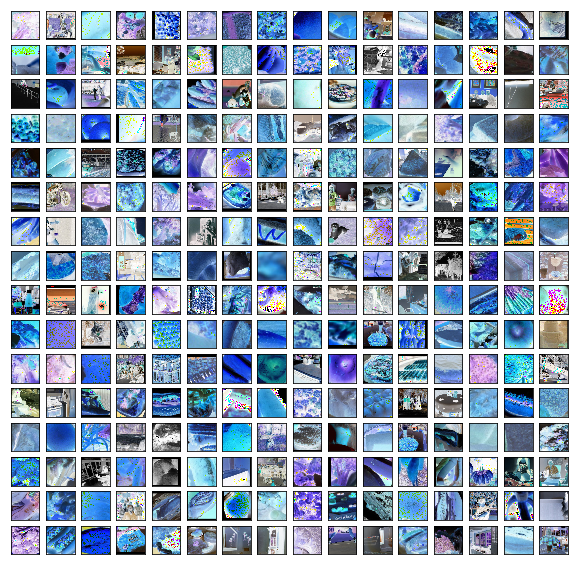

In [9]:
show_images(imgs.transpose((0,2,3,1)), 16, 16, figsize=(10,10))

## DeepDog Net

In [10]:
from mxnet.gluon.model_zoo import vision as models 

SqueezeNet = models.squeezenet1_1(pretrained=True, prefix='deep_dog_')
SqueezeNet.output

HybridSequential(
  (0): Conv2D(512 -> 1000, kernel_size=(1, 1), stride=(1, 1))
  (1): Activation(relu)
  (2): AvgPool2D(size=(13, 13), stride=(13, 13), padding=(0, 0), ceil_mode=False)
  (3): Flatten
)

In [11]:
deep_dog_net = models.squeezenet1_1(prefix='deep_dog_', classes=2)
deep_dog_net.collect_params().initialize()
deep_dog_net.features = SqueezeNet.features
iamgenet_hotdog_index = 713
deep_dog_net

SqueezeNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2))
    (1): Activation(relu)
    (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
    (3): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(64 -> 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(1, 1), stride=(1, 1))
          (1): Activation(relu)
        )
        (1): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Activation(relu)
        )
      )
    )
    (4): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(128 -> 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(1, 1), stride=(1, 1))
      

## 模型和训练

In [27]:
from skimage.color import rgba2rgb

def classify_hotdog(net, fname, ctx):
    with open(fname, 'rb') as f:
        img = image.imdecode(f.read())
    if img.shape[2] == 4:
        img = rgba2rgb(img)
    plt.subplot(1,2,1)
    plt.imshow(img.asnumpy())
    img_crop = image.resize_short(img, 256)
    img_crop, _ = image.center_crop(img_crop, (224,224))
    plt.subplot(1,2,2)
    plt.imshow(img_crop.asnumpy())
    # prediction
    img_crop = image.color_normalize(img_crop.astype(np.float32)/255, 
                                     mean=nd.array([0.485,0.456,0.406]),
                                     std=nd.array([0.229,0.224,0.225]))
    img_crop = nd.expand_dims(img_crop, axis=0)
    img_crop = img_crop.transpose((0,3,2,1)).astype('float32')
    img_crop = img_crop.as_in_context(ctx)
    output = net(img_crop)
    output = nd.SoftmaxActivation(output)
    pred = int(nd.argmax(output, axis=1).asscalar())
    prob = output[0][pred].asscalar()
    print(output[0])
    outstring = ['Not-Hotdog', 'Hotdog']
    return '{}, With prob : {}'.format(outstring[pred], prob)


[0.12062811 0.8793719 ]
<NDArray 2 @gpu(0)>


'Hotdog, With prob : 0.8793718814849854'

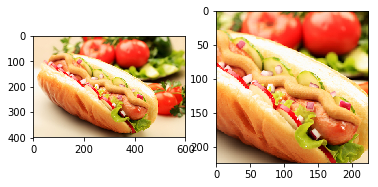

In [30]:
classify_hotdog(deep_dog_net, 'real_hotdog.jpg', ctx=mx.gpu())

In [14]:
deep_dog_net.output

HybridSequential(
  (0): Conv2D(512 -> 2, kernel_size=(1, 1), stride=(1, 1))
  (1): Activation(relu)
  (2): AvgPool2D(size=(13, 13), stride=(13, 13), padding=(0, 0), ceil_mode=False)
  (3): Flatten
)

## 参数重用

注意卷积层中$weight$的$shape$格式为 ： $output\_channel \times input\_channel \times height \times width $

In [15]:
imagenet_hotdog_index = 713

pretrained_weight = SqueezeNet.output[0].weight
pretrained_bias = SqueezeNet.output[0].bias

hotdog_w = nd.split(pretrained_weight.data(), 1000, axis=0)[imagenet_hotdog_index]
hotdog_b = nd.split(pretrained_bias.data(), 1000, axis=0)[imagenet_hotdog_index]

new_hotdog_weight = nd.concat(nd.random.normal(0, np.sqrt(2 / hotdog_w.shape[1]), shape=hotdog_w.shape), 
                             hotdog_w, dim=0)
new_hotdog_bias = nd.concat(nd.random.normal(0, np.sqrt(2 / hotdog_b.shape[0]), shape=hotdog_b.shape),
                             hotdog_b, dim=0)

# 我们将重用好的imagenet参数添加到deep_dog_net的输出层中的卷积层上
final_conv_layer_params = deep_dog_net.output[0].params
final_conv_layer_params.get('weight').set_data(new_hotdog_weight)
final_conv_layer_params.get('bias').set_data(new_hotdog_bias)
final_conv_layer_params

deep_dog_conv25_ (
  Parameter deep_dog_conv25_weight (shape=(2, 512, 1, 1), dtype=<class 'numpy.float32'>)
  Parameter deep_dog_conv25_bias (shape=(2,), dtype=<class 'numpy.float32'>)
)

In [16]:
# 查看参数是否正确
deep_dog_net.output[0].params

deep_dog_conv25_ (
  Parameter deep_dog_conv25_weight (shape=(2, 512, 1, 1), dtype=<class 'numpy.float32'>)
  Parameter deep_dog_conv25_bias (shape=(2,), dtype=<class 'numpy.float32'>)
)

## 评估函数

#### <font color="red">这里我们要掌握``metric``评估函数的用法

In [17]:
def metric_str(names, accs):
    return ', '.join(['%s = %f' % (name, acc) for name, acc in zip(names, accs)])

metric = mx.metric.create(['acc', 'f1'])

def evaluate(net, data_iter, ctx):
    data_iter.reset()
    for batch in data_iter:
        # 使用model_zoo的模型时，我们需要将数据在宫格通道上归一化
        data = image.color_normalize(batch.data[0] / 255, 
                                     mean=nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                     std=nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        
        # 将一个batch平均分到不同的ctx上，其中维度0表示batch维度
        data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
        labels = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        
        preds = []
        for X in data:
            preds.append(net(X))
        metric.update(labels, preds)
    outputs = metric.get()
    metric.reset()
    return outputs

In [18]:
deep_dog_net.collect_params().reset_ctx([mx.gpu()])
evaluate(deep_dog_net, val_iter, ctx=[mx.gpu()])

(['accuracy', 'f1'], [0.44453125, 0.21486802617856834])

## 训练

我们编写支持多GPU的训练代码，便于重用

In [19]:
def train(net, train_iter, val_iter, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
        
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':learning_rate, 'wd': wd})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    
    best_f1 = 0 # 记录最好的 val_acc
    val_names, val_accs = evaluate(net, val_iter, ctx)# initial val_acc
    logging.info('[Initial] Validation: %s.' % (metric_str(val_names, val_accs)))
    for epoch in range(epochs):
        # 每次遍历batch之前要reset一下我们的train_iter，避免不必要的影响
        train_iter.reset()
        start = time()
        for batch in train_iter:
            data = image.color_normalize(batch.data[0] / 255, 
                                         mean=nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                         std=nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            # 将数据分发到不同设备上
            data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
            labels = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
            
            # 因为是多GPU，因此我们使用Ls来存每个gpu上
            Ls = []
            outputs = []
            with autograd.record():
                for  X, y in zip(data, labels):
                    out = net(X)
                    # loss这边没有考虑样本的不平衡性 后面乘上的是为了考虑样本的不平衡性
                    L = loss(out, y) * (1+y*positive_class_weight) / positive_class_weight
                    Ls.append(L)
                    outputs.append(out)
            for l in Ls:
                l.backward()
            trainer.step(batch.data[0].shape[0])
            metric.update(labels, outputs)
        names, accs = metric.get()
        metric.reset()
        # logging
        logging.info('[Epoch %d] Training : %s.' % (epoch, metric_str(names, accs)))
        logging.info('[Epoch %d] Time Consume : %f.' % (epoch, time() - start))
        val_names, val_accs = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] Validation : %s.' % (epoch, metric_str(val_names, val_accs)))
        
        # save models
        if val_accs[1] > best_f1:
            best_f1 = val_accs[1]
            logging.info('Best Validation f1 found. CheckPointing....')
            net.save_params('deep-dog-%d.params' % (epoch))

In [20]:
gpus = 1
# hybrid block
deep_dog_net.hybridize()
contexts = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]
deep_dog_net.collect_params().reset_ctx(contexts)
train(deep_dog_net, train_iter, val_iter, contexts)

INFO:root:[Initial] Validation: accuracy = 0.442969, f1 = 0.210528.
INFO:root:[Epoch 0] Training : accuracy = 0.729995, f1 = 0.366029.
INFO:root:[Epoch 0] Time Consume : 50.712000.
INFO:root:[Epoch 0] Validation : accuracy = 0.772656, f1 = 0.563750.
INFO:root:Best Validation f1 found. CheckPointing....
INFO:root:[Epoch 1] Training : accuracy = 0.790956, f1 = 0.466979.
INFO:root:[Epoch 1] Time Consume : 48.785000.
INFO:root:[Epoch 1] Validation : accuracy = 0.857812, f1 = 0.653925.
INFO:root:Best Validation f1 found. CheckPointing....
INFO:root:[Epoch 2] Training : accuracy = 0.820549, f1 = 0.514108.
INFO:root:[Epoch 2] Time Consume : 50.192000.
INFO:root:[Epoch 2] Validation : accuracy = 0.800781, f1 = 0.614179.
INFO:root:[Epoch 3] Training : accuracy = 0.834813, f1 = 0.541436.
INFO:root:[Epoch 3] Time Consume : 48.324000.
INFO:root:[Epoch 3] Validation : accuracy = 0.797656, f1 = 0.601792.
INFO:root:[Epoch 4] Training : accuracy = 0.841442, f1 = 0.551835.
INFO:root:[Epoch 4] Time Cons

In [25]:
deep_dog_net.load_params('deep-dog-27.params', ctx=mx.gpu())


[9.9999475e-01 5.2245432e-06]
<NDArray 2 @gpu(0)>


'Not-Hotdog, With prob : 0.9999947547912598'

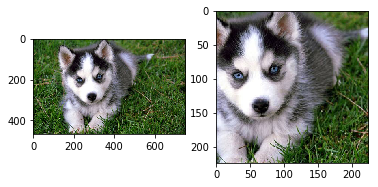

In [33]:
classify_hotdog(deep_dog_net, 'dog.jpg', ctx=mx.gpu())